## Use Spark SQL for big data analysis on SF crime data.

Data: https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data

Part 1: Import Package and Data Preprocessing

Part 2: Transform Distributed Data into Dataframe and SQL Table

Part 3: OLAP (Online Analytical Processing)

Part 4: Apply Spark ML Clustering for Spatial Data Analysis

Part 5: Conclusion

### Part 1: Import Package and Data Preprocessing

#### Part 1.1: Import Package

In [5]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from ggplot import *
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python2"

#### Part 1.2: Data Preprocessing

In [7]:
#upload data into databricks community at first
#read data from the data storage
crime_data_lines = sc.textFile('/FileStore/tables/sf_data_03_18.csv')
#prepare data
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
print(header)

['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId']

In [8]:
#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

#get the first line of data
display(crimes.take(3))

_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821003074
150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821004014


In [9]:
#get the total number of data 
print(crimes.count())

2215024

###Part 2: Transform Distributed Data into Dataframe and SQL Table

In [11]:
df_opt1 = crimes.toDF(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
display(df_opt1.take(3))
df_opt1.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821003074
150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821004014


In [12]:
from pyspark.sql import Row

def createRow(keys, values):
  assert len(keys) == len(values)
  mapped = dict(zip(keys, values))
  return Row(**mapped)

rdd_rows = crimes.map(lambda x: createRow(header, x))

df_opt2 = spark.createDataFrame(rdd_rows)
df_opt2.createOrReplaceTempView("sf_crime")
display(df_opt2.take(3))

Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,Time,X,Y
18TH ST / VALENCIA ST,NON-CRIMINAL,01/19/2015,Monday,LOST PROPERTY,150060275,"(37.7617007179518, -122.42158168137)",MISSION,15006027571000,NONE,14:00,-122.42158168137,37.7617007179518
300 Block of LEAVENWORTH ST,ROBBERY,02/01/2015,Sunday,"ROBBERY, BODILY FORCE",150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821003074,NONE,15:45,-122.414406029855,37.7841907151119
300 Block of LEAVENWORTH ST,ASSAULT,02/01/2015,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821004014,NONE,15:45,-122.414406029855,37.7841907151119


In [13]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt3 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/sf_data_03_18.csv")
display(df_opt3.take(3))
df_opt3.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821003074
150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821004014


###Part 3: OLAP (Online Analytical Processing)

#### Part 3.1: Count the Number of Crimes for Different Category

In [16]:
#Spark SQL based
crimeCategory = spark.sql("SELECT category as Category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory.take(3))

Category,Count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323


In [17]:
q1_result = df_opt3.groupBy('Category').count().orderBy('Count', ascending=False)
display(q1_result.take(3))

Category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323


In [18]:
catorgory_set_rdd = crimes.map(lambda item: (item[1],1))
from operator import add
result = sorted(catorgory_set_rdd.reduceByKey(add).collect(), key = lambda item: -item[1])
#display(result)

In [19]:
# important hints:
## first step: spark df or sql to compute the statistic result
## second step: export your results to a pandas dataframe

crimes_pd_df = crimeCategory.toPandas()

print(crimes_pd_df)

Category Count
0 LARCENY/THEFT 480448
1 OTHER OFFENSES 309358
2 NON-CRIMINAL 238323
3 ASSAULT 194694
4 VEHICLE THEFT 126602
5 DRUG/NARCOTIC 119628
6 VANDALISM 116059
7 WARRANTS 101379
8 BURGLARY 91543
9 SUSPICIOUS OCC 80444
10 MISSING PERSON 64961
11 ROBBERY 55867
12 FRAUD 41542
13 SECONDARY CODES 25831
14 FORGERY/COUNTERFEITING 23050
15 WEAPON LAWS 22234
16 TRESPASS 19449
17 PROSTITUTION 16701
18 STOLEN PROPERTY 11891
19 SEX OFFENSES, FORCIBLE 11742
20 DISORDERLY CONDUCT 10040
21 DRUNKENNESS 9826
22 RECOVERED VEHICLE 8716
23 DRIVING UNDER THE INFLUENCE 5672
24 KIDNAPPING 5346
25 RUNAWAY 4440
26 LIQUOR LAWS 4083
27 ARSON 3931
28 EMBEZZLEMENT 2988
29 LOITERING 2430
30 SUICIDE 1292
31 FAMILY OFFENSES 1183
32 BAD CHECKS 925
33 BRIBERY 813
34 EXTORTION 741
35 SEX OFFENSES, NON FORCIBLE 431
36 GAMBLING 348
37 PORNOGRAPHY/OBSCENE MAT 59
38 TREA 14

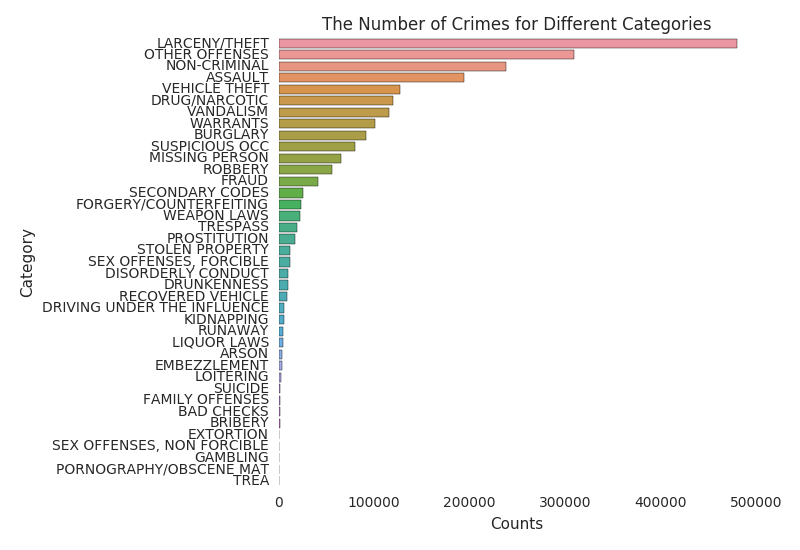

In [20]:
#crimes_pd_df.plot.bar(x='Category', y='Count', rot=90)
#p = plt.show()
#display(p)

fig, axes = plt.subplots(1,1)

sb.barplot(y="Category", x="Count", data=crimes_pd_df, ax=axes)
plt.xlabel("Counts")
plt.title("The Number of Crimes for Different Categories")
plt.tight_layout()
display(fig.show())

#### Part 3.2: Count the Number of Crimes for Different District

In [22]:
crimeDistrict = spark.sql("SELECT PdDistrict, COUNT(*) AS Count FROM sf_crime GROUP BY PdDistrict ORDER BY Count DESC")
display(crimeDistrict)

PdDistrict,Count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713
CENTRAL,226255
BAYVIEW,221000
INGLESIDE,194180
TENDERLOIN,191746
TARAVAL,166971
PARK,125479
RICHMOND,116818


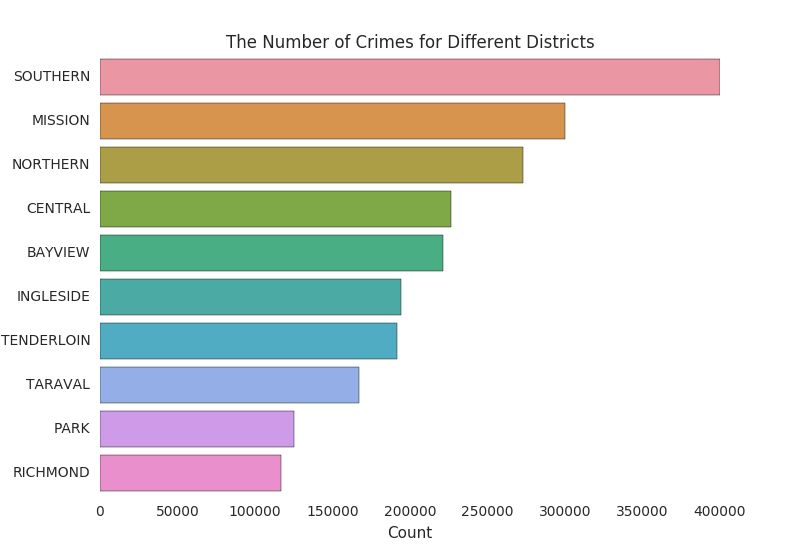

In [23]:
# important hints:
## first step: spark df or sql to compute the statistic result
## second step: export your results to a pandas dataframe

crimeDistrict_pd_df = crimeDistrict.toPandas()
#print(crimes_pd_df)

#crimeDistrict_pd_df.plot.bar(x = 'PdDistrict', y = 'Count', rot = 90)
#p = plt.show()
#display(p)

fig, axes = plt.subplots(1,1)
sb.barplot(y="PdDistrict", x="Count", data=crimeDistrict_pd_df, ax=axes)
plt.xlabel("Count")
plt.ylabel("District")
plt.title("The Number of Crimes for Different Districts")
display(fig.show())

#### Part 3.3: Count the Number of Crimes each Sunday at SF Downtown

Hints: SF downtown is defiend  via the range of spatial location. Thus, you need to write your own UDF function to filter data which are located inside certain spatial range. Example here: https://changhsinlee.com/pyspark-udf/

In [26]:
count_Sun_DT =df_opt1[df_opt1['DayOfWeek'] == "Sunday"].filter(df_opt1["X"].between(-122.404698,-122.398216) & df_opt1["Y"].between(37.786702,37.797962)).groupby('Date').count() 
display(count_Sun_DT.take(3))

Date,count
12/13/2009,7
07/24/2005,5
12/26/2004,1


In [27]:
# SF Downtown 六个顶点坐标
vertx_lst = [-122.407011, -122.404671, -122.395166, -122.396818, -122.397805, -122.398212]
verty_lst = [37.797813, 37.786689, 37.794218, 37.795540, 37.798525, 37.798932]
nvert = len(vertx_lst)

# 判断是否在多边形中的函数
def pnpoly(nvert, vertx_list, verty_list, tests):
    testy, testx = tests.split(',')
    y = float(testy)
    x = float(testx)
    is_in = 0
    if not min(vertx_list) <= x <= max(vertx_list) or not min(verty_list) <= y <= max(verty_list):
        return 0
    for i in range(nvert):
        j = nvert - 1 if i == 0 else i - 1
        if ((verty_list[i] > y) != (verty_list[j] > y)) and (
                    x < (vertx_list[j] - vertx_list[i]) * (y - verty_list[i]) / (verty_list[j] - verty_list[i]) + vertx_list[i]):
            is_in = 1

    return is_in

In [28]:
# UDF
from pyspark.sql.types import IntegerType
chooseSF_Downtown = udf(lambda loc_str: pnpoly(nvert, vertx_lst, verty_lst, loc_str[1:-1]), IntegerType())

In [29]:
sunday_df = spark.sql("SELECT * FROM sf_crime WHERE dayofweek='Sunday' ")
isSFDowntown = sunday_df.select('Date', chooseSF_Downtown('Location').alias('Is_In_SF_Downtown'))
isSFDowntown = isSFDowntown.filter(isSFDowntown['Is_In_SF_Downtown'] == 1).groupby('Date').count().withColumnRenamed('Count', 'Sunday Crimes')
display(isSFDowntown.take(3))

Date,Sunday Crimes
06/26/2005,14
07/24/2005,8
11/17/2013,11


#### Part 3.4: Analyze the Number of Crimes in Each Month of 2015, 2016, 2017, and 2018

In [31]:
count_by_year = spark.sql("SELECT SUBSTRING(Date, 0, 2) AS Month, count(*) AS Count FROM sf_crime WHERE SUBSTRING(Date, 7, 10) IN ('2018','2017','2016','2015') GROUP BY Month ORDER BY Month ASC")
display(count_by_year.take(3))

Month,Count
01,51688
02,46574
03,50760


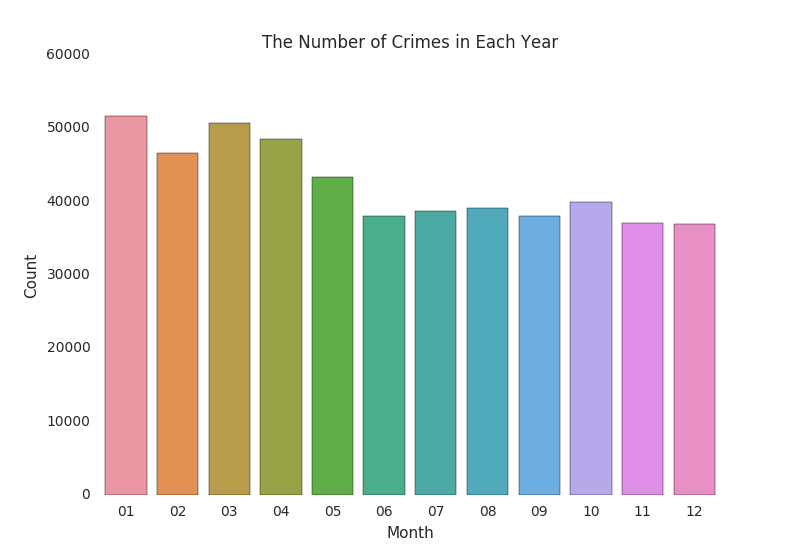

In [32]:
count_by_year_pd = count_by_year.toPandas()

fig, axes = plt.subplots(1,1)
sb.barplot(y="Count", x="Month", data=count_by_year_pd, ax=axes)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("The Number of Crimes in Each Year")
display(fig.show())

Insights:

I would suggest to visit SF during summer and fall. Winter is the most dangerous season.

#### Part 3.5: Analyze the Number of Crimes w.r.t the Hour in Certian Day Like 2015/12/15, 2016/12/15, 2017/12/15, and 2018/10/15

In [35]:
count_by_hour = spark.sql("SELECT HOUR(Time) as Hour, COUNT(*) as Count FROM sf_crime WHERE Date IN ('12/15/2015','12/15/2016','12/15/2017','10/15/2018') GROUP BY Hour ORDER BY Hour ASC")  
display(count_by_hour)

Hour,Count
0,67
1,28
2,25
3,17
4,20
5,11
6,15
7,22
8,62
9,47


Insights:

It's better to visit SF in early morning or early afternoon. 4 pm to 7 pm is the most dangerous time to visit.

#### Part 3.6: Analyze the Number of Crimes w.r.t Category and Time in Top-3 Dangerous Distrct

In [38]:
#step 1: Find out the top-3 danger disrict
crimeDistrict = spark.sql("SELECT PdDistrict, COUNT(*) AS Count FROM sf_crime GROUP BY PdDistrict ORDER BY Count DESC")
top3 = crimeDistrict.take(3)
display(top3)

PdDistrict,Count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713


In [39]:
#step 2: The crime event w.r.t category
Danger_Category_Count = spark.sql("SELECT Category, COUNT(*) AS Count FROM sf_crime WHERE PdDistrict IN ('SOUTHERN','MISSION','NORTHERN') GROUP BY Category ORDER BY Count DESC")
display(Danger_Category_Count)

Category,Count
LARCENY/THEFT,243290
OTHER OFFENSES,129739
NON-CRIMINAL,108217
ASSAULT,81163
DRUG/NARCOTIC,50903
WARRANTS,49254
VANDALISM,46032
VEHICLE THEFT,43573
BURGLARY,36500
SUSPICIOUS OCC,31785


In [40]:
#Step 2: The crime event w.r.t time(hour)
Danger_Hour_Count = spark.sql("SELECT HOUR(Time) as Hour, COUNT(*) as Count FROM sf_crime WHERE PdDistrict IN ('SOUTHERN','MISSION','NORTHERN') GROUP BY Hour ORDER BY Count DESC")
display(Danger_Hour_Count)

Hour,Count
18,62045
17,58578
19,57192
12,55594
16,54053
0,51440
20,51172
15,50965
22,50652
21,48557


Advice to distribute the police based on your analysis results:

We should distribute more police in Southern, Mission and Northern area from 4 pm to 11 pm.

####Part 3.7: Find the Percentage of Resolution for Different Category of Crime

In [43]:
crime_category_resolution_percentage = spark.sql("SELECT category as Category, CAST(SUM(CASE WHEN Resolution = 'NONE' THEN 0 ELSE 1 END) *100.0 / COUNT(*) AS DECIMAL (10,2)) AS Percentage FROM sf_crime GROUP BY category ORDER BY percentage DESC")
display(crime_category_resolution_percentage)

Category,Percentage
PROSTITUTION,94.91
WARRANTS,94.59
DRIVING UNDER THE INFLUENCE,94.41
DRUG/NARCOTIC,91.41
LIQUOR LAWS,88.95
STOLEN PROPERTY,87.9
LOITERING,87.7
DRUNKENNESS,82.44
WEAPON LAWS,72.7
OTHER OFFENSES,71.6


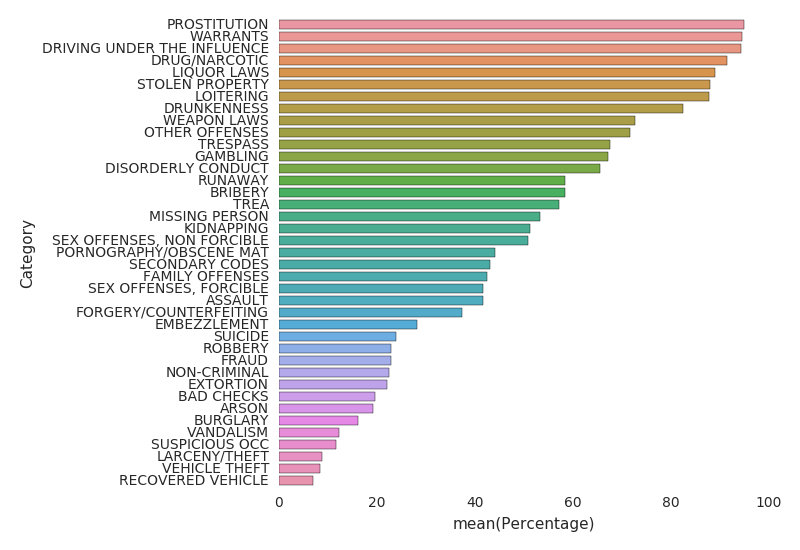

In [44]:
crime_category_resolution_percentage_pd = crime_category_resolution_percentage.toPandas()
fig, axes = plt.subplots(1,1)
sb.barplot(x="Percentage", y="Category", data=crime_category_resolution_percentage_pd, ax=axes)
plt.tight_layout()
display(fig.show())

Advice to distribute the police based on your analysis results:

From the data report, the top 5 unresloved crime categories are recovered vehicles, vehicle theft, larceny/theft, suspicious occ, and vandalism. Police can focus more on theft issues and vandalism.

###Part 4: Apply Spark ML Clustering for Spatial Data Analysis

Visualize the spatial distribution of crimes and run a kmeans clustering algorithm using Spark ML kmeans  
Example: https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [48]:
# select data
cluster_df = df_opt1.select(['IncidntNum', 'X', 'Y'])
display(cluster_df.take(3))

IncidntNum,X,Y
150060275,-122.42158168137,37.7617007179518
150098210,-122.414406029855,37.7841907151119
150098210,-122.414406029855,37.7841907151119


In [49]:
# preprocess data
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

# build a new df
features_col = ['X', 'Y']
for col in cluster_df.columns:
  if col in features_col:
    cluster_df = cluster_df.withColumn(col, cluster_df[col].cast('double'))    

# interaction: takes vector or double-valued columns, and generates a single vector column that contains the product of all combinations of one value from each input column. https://spark.apache.org/docs/latest/ml-features
vecAssembler = VectorAssembler(inputCols=['X', 'Y'], outputCol='features')
df_to_kmeans = vecAssembler.transform(cluster_df)
display(df_to_kmeans.take(3))
df_to_kmeans = df_to_kmeans.select('IncidntNum', 'features')

IncidntNum,X,Y,features
150060275,-122.42158168137,37.7617007179518,"List(1, 2, List(), List(-122.42158168137, 37.7617007179518))"
150098210,-122.414406029855,37.7841907151119,"List(1, 2, List(), List(-122.414406029855, 37.7841907151119))"
150098210,-122.414406029855,37.7841907151119,"List(1, 2, List(), List(-122.414406029855, 37.7841907151119))"


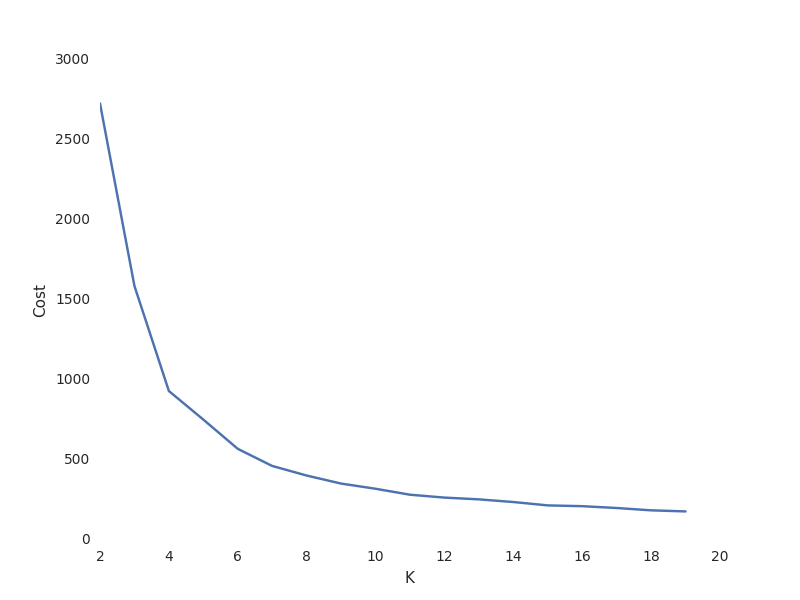

In [50]:
# choose k
cost = np.zeros(20)
for k in range(2,20):
  kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
  model = kmeans.fit(df_to_kmeans.sample(False, 0.1, seed=42))
  cost[k] = model.computeCost(df_to_kmeans)
  
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2,20), cost[2:20])
ax.set_xlabel('K')
ax.set_ylabel('Cost')
display(fig.show())

In [51]:
# choose k = 18 and train a k-means model.
kmeans = KMeans().setK(18).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_to_kmeans)
centers = model.clusterCenters()

In [52]:
# make predictions
trans = model.transform(df_to_kmeans)
#trans = trans.select('IncidntNum', 'features', 'prediction')
display(trans.take(3))

IncidntNum,features,prediction
150060275,"List(1, 2, List(), List(-122.42158168137, 37.7617007179518))",9
150098210,"List(1, 2, List(), List(-122.414406029855, 37.7841907151119))",0
150098210,"List(1, 2, List(), List(-122.414406029855, 37.7841907151119))",0


In [53]:
res = cluster_df.join(trans, trans.IncidntNum == cluster_df.IncidntNum)
display(res.take(3))

IncidntNum,X,Y,IncidntNum,features,prediction
020092667,-122.429042228263,37.7818456494851,020092667,"List(1, 2, List(), List(-122.429042228263, 37.7818456494851))",15
021205328,-122.413259498719,37.7829514828801,021205328,"List(1, 2, List(), List(-122.413259498719, 37.7829514828801))",0
021467590,-122.420004126989,37.7829415360009,021467590,"List(1, 2, List(), List(-122.420004126989, 37.7829415360009))",15


In [54]:
res = res.drop(trans.IncidntNum)
res1 = res.drop('features', 'IncidntNum')
res1 = res1.withColumn("X", res1.X.cast('double'))
res1 = res1.withColumn("Y", res1.Y.cast('double'))
display(res1.take(3))

X,Y,prediction
-122.429042228263,37.7818456494851,15
-122.413259498719,37.7829514828801,0
-122.420004126989,37.7829415360009,15


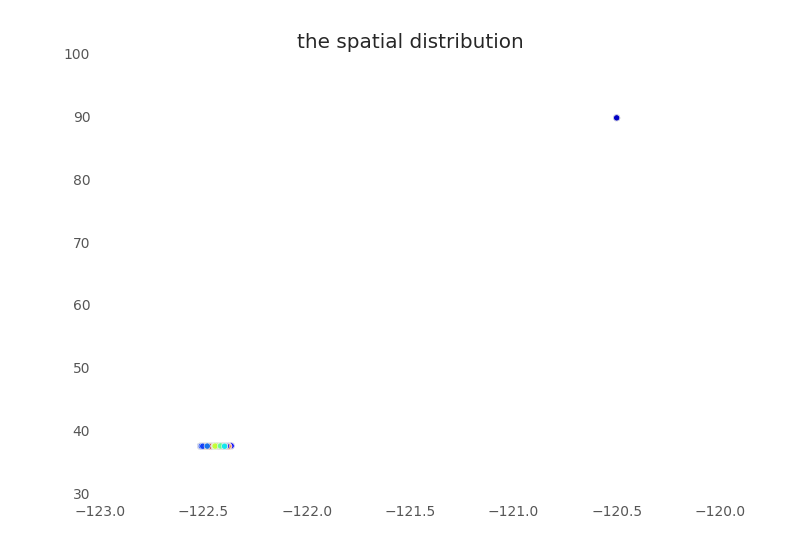

In [55]:
res2 = res1.toPandas()
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.scatter(res2['X'], res2['Y'], c=(res2['prediction']),cmap=plt.cm.jet, alpha=0.9)
ax.set_title("the spatial distribution")
display()

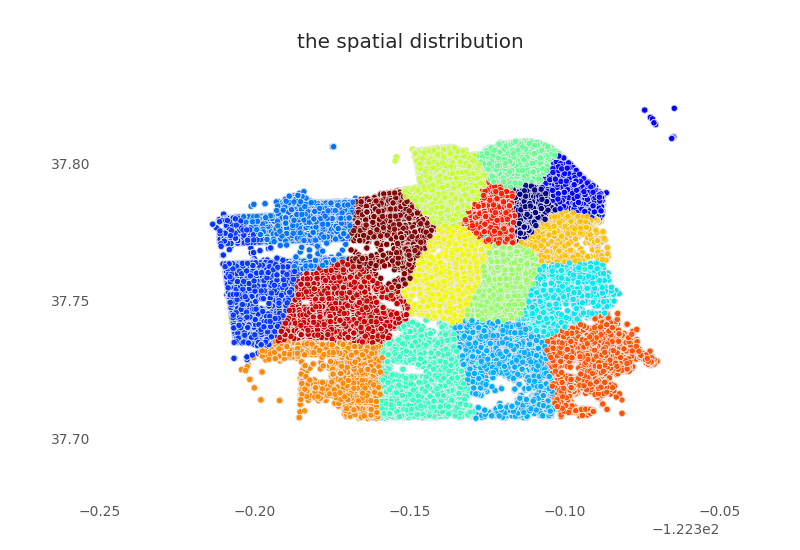

In [56]:
res1 = res1.filter(res1.X < -122)
res2 = res1.toPandas()
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.scatter(res2['X'], res2['Y'], c=(res2['prediction']),cmap=plt.cm.jet, alpha=0.9)
ax.set_title("the spatial distribution")
display()

###Part 5: Conclusion

In this project, I built a data processing pipeline based on Spark SQL for a 15-year dataset of reported incidents from SFPD. I performed OLAP on crime situation in terms of crime category, district, time. 
  
  Here are my suggestions based on my analysis:
  
  1) We should visit SF during summer and fall. Winter is the most dangerous season. 
  
  2) It's better to visit SF in early morning or early afternoon. 4 pm to 7 pm is the most dangerous time to visit.
  
  3) We should distribute more police in Southern, Mission and Northern area from 4 pm to 11 pm. 
  
  4) Police can focus more on theft issues and vandalism.
  
  In the end, I explored and visualized the variation of the spatial distribution of incidents over time by applying k-means clustering algorithm with optimal k value.